# 1. 웹사이트 크롤링

In [1]:
# !pip install googletrans==3.1.0a0 

In [2]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import pandas as pd
import openai
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]{0,1}://.+$'

# Define root domain to crawl
# domain = "openai.com"
# full_url = "https://openai.com/"
# domain = "inswave.com"
# full_url = "https://inswave.com/confluence/pages/viewpage.action?pageId=6030702"
# domain = "docs1.inswave.com"
# full_url = "https://docs1.inswave.com/sp5_user_guide"

# domain = "docs2.inswave.com"
# full_url = "http://docs2.inswave.com/ws5_sp5_example"
domain = "localhost:8080"
full_url = "http://localhost:8080/websquare/guide/websquaretoc.html"
# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "http://" + local_domain + "/" + link
#             clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))


def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        path = url[8:].replace("/", "_")
        m = re.search('(.+?)[#]', path)
        if m:
            path = m.group(1)

        # Save text from the url to a <url>.txt file
#         with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:
        with open('text/'+local_domain+'/'+ path + ".txt", "w") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()
            
            
            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)



In [3]:
# crawl(full_url)

# 2. 다운받은 컨텐츠를 정리한 다음 영어로 번역

In [4]:
def remove_newlines(serie):
    serie = serie.replace('\t', ' ')
    serie = serie.replace('\n', ' ')
    serie = serie.replace('\r', ' ')
    serie = serie.replace('\\r', ' ')
    serie = serie.replace('\\n', ' ')
    serie = serie.replace('             ', ' ')
    serie = serie.replace('            ', ' ')
    serie = serie.replace('           ', ' ')
    serie = serie.replace('          ', ' ')
    serie = serie.replace('         ', ' ')
    serie = serie.replace('        ', ' ')
    serie = serie.replace('       ', ' ')
    serie = serie.replace('      ', ' ')
    serie = serie.replace('     ', ' ')
    serie = serie.replace('    ', ' ')
    serie = serie.replace('   ', ' ')
    serie = serie.replace('  ', ' ')
    serie = serie.replace('  ', ' ')
    serie = serie.replace(' ', ' ')
    return serie

In [5]:
# Function to split the text into chunks of a maximum number of tokens
def split_str_into_many(text, max_tokens = 4000):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(" " + sentence) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

        
    chunks.append(". ".join(chunk) + ".")
        
    return chunks
    

In [6]:
!pip3 install googletrans==3.1.0a0

In [7]:
from googletrans import Translator
translator = Translator()
translation = translator.translate('안녕하세요.')
print(translation.origin, ' -> ', translation.text)


안녕하세요.  ->  hello.


In [8]:
# aaa = '''Group 컴포넌트와 동일하게 외부 스타일 시트 작성이 더 수월하면 Style 창에 스타일 입력을 건너띄어도 무방합니다.그림 77-8.작성한 외부 CSS그림 77-9.데이터 헤더에 해당되는 스타일의 클래스 삽입그림 77-10.데이터 셀에 해당되는 스타일의 클래스 삽입그림 77-11.데이터 행에 해당되는 스타일의 클래스 삽입그림 77-12.테이블에 해당되는 스타일의 클래스 삽입. 두가지 이상의 클래스를 합성 하고 싶을 경우에는 html 코딩과 동일하게 class 속성에 클래스 사이를 공백으로 띄어 적용할 수 있다.그림 77-13.파싱된 구조테이블 관련 요소가 될 컴포넌트에 스타일을 적용시키고 브라우저 개발자 도구로 확인을 해봅니다. 개발자 도구를 통해서 본 파싱된 결과물은 스타일 시트에 의해테이블의 형태를 취하고 있고, 각 요소들이 테이블과 유사한 부모-자식간의 관계가 되어있지만, 파싱된 마크업이 div로 (div는 division으로 영역을 나누는(레이아웃) 용도의 태그) 의미있는 마크업이 아니기에 문서상의 테이블을 의미하는 코딩을 했다고 할 수 없을 것입니다. 여기까지 만들어진 샘플을 토대로 tagname 변경으로 간단한 테이블 마크업을 해보겠습니다.77.3마크업 변경과 속성 추가하기WebSquare의 컴포넌트 중 가장 빈번히 사용되는 컴포넌트인 Group과 Textbox 컴포넌트는 tagname 속성을 제공하여 파싱될 마크업을 변경하여 사용자가 원하는 대로 마크업을 할 수 있습니다. 두 컴포넌트 모두 tagname 변경 방법은 동일합니다. Group 컴포넌트와 같은 방법으로 해당 Textbox 컴포넌트를 Design View에서 선택하고, Property창의 tagname을 변경하면 됩니다.전 챕터(2.1.1)에서 만들었던 디자인을 적용한 샘플을 복사하여 tagname 변경을 해보도록 하겠습니다. WebSqaure는 컴포넌트를 쉽고 빠르게 복사하여 생산성을 높일 수 있습니다. Component 창에서 복사할 컴포넌트를 오른쪽 클릭하여'복사'를 누른 후, 원하는 위치(부모가 될 컴포넌트)를 선택한 후 오른쪽 클릭하여 붙여넣기를 선택하면 됩니다. id는 WebSquare 에서 자동으로 1씩 증가한 만큼 넣어주어 id 중복 문제가 일어나지 않도록 해줍니다.그림 77-14.56비교적 명확한 요소 이름을 가진 데이터의 헤더 부터 tagname 부터 적용해 보겠습니다.<table> 예제는 tableLayout을 사용하는 것을 권장하며 개별적으로 작성하기 위한 방법으로 아래 방법을 참고하겠습니다. HTML 페이지를 작성하는 것과 같이 <table>에 대한 스타일 시트를 따로 작성하겠습니다.그림 77-15.새로 작성한 table 관련 스타일 시트<table>에 관한 스타일 시트가 완성되었으니, 복사한 컴포넌트에 CSS Class를 입력합니다. 입력한 후에 Design View에 적용이 안되는 이유는 스타일 시트 작성이 요소 선택자로 tr, th, td 에 대한 스타일이기 때문에 파싱될 마크업(tagname 속성)이 설정되어있지 않아 div로 표현되어서 그렇습니다. 그렇다면, 스타일 적용을 확인하기 위해 각각 그룹핑 되어있는 컴포넌트들을 table 코딩이었을 때에 매치되는 마크업으로 변경해 보도록 하겠습니다.브라우저에 파싱될 마크업을 수정하는 것은 Group 컴포넌트와 동일하게 Property 창에서 tagname 속성을 수정하면 됩니다. 제일 명확한 마크업인 데이터의 헤더인 th 부분을 먼저 수정해 보겠습니다. Design View에서 데이터 헤더에 해당되는 컴포넌트를 선택하고, Property창의 tagname을 선택하여 'th'를 직접입력 하거나찾아넣습니다.그림 77-16.데이터 헤더 셀이 될 컴포넌트에 th를 입그림 77-17.데이터 셀이 될 컴포넌트에 td를 입그림 77-18.테이블의 행이 될 컴포넌트에 tr을 입력그림 77-19.테이블이 될 컴포넌트에 table을 입력그림 77-20.브라우저에서의 화면 확인 및 파싱 결과 확인tagname을 수정하여 마크업이 결정되었습니다. 이제 가로형 테이블이니, 데이터 헤더에 대한 제목 범위를 지정하는 'scope' 속성을 추가하면 기본적인 table 마크업이 완성됩니다. 'scope' 속성이 없어도 정상적으로 브라우저 화면에서 나오나, 접근성 작업시 'scope' 속성은 반드시 넣어주셔야 합니다.Textbox 컴포넌트의 속성 추가는 Group 컴포넌트의 속성 추가와 같은 방법으로 'scope' 속성을 추가하기 위해서 th와 매칭되는 Textbox 컴포넌트를 Component 창에서 선택하고 오른쪽 클릭하여 '속성 태그 수정'을 선택하여 추가합니다.그림 77-21.tagname을 th로 준 컴포넌트의 scope 속성 추가그림 77-22.속성을 추가한 뒤에 브라우저에서 결과 확인접근성을 위해 <caption>코딩, summary Attibute 삽입하고 싶다면, 이전 코딩 방법과 동일하게 Table이 될 Group 컴포넌트에 Textbox 컴포넌트를 삽입하고 tagname을 caption으로 직접 입력하여 바꾸고, 속성 추가하기 컨텍스트 메뉴로 추가할 수 있습니다.더 세밀한 웹표준과 웹접근성을 준수하는 table 코딩 및 내용이 정적·동적인 table 을 하기 위해서는 여러가지 컴포넌트의 조합이 필요한 경우가 있기에, 다음 장인 다른 어떤 컴포넌트와 Group 컴포넌트, Textbox 컴포넌트의 조합 파트를 참고하시기 바랍니다.77.4CSS Overriding그림 77-23.02NoClassDescription1w2textboxw2textbox은 웹스퀘어 엔진에서 정의된 클래스입니다, 브라우저가 파싱할때 자동으로 부여됩니다.2inlinewebsquare의 style 편집기에서 해당 style을 직접 수정합니다.77.5주의사항 및 TipProperty > for 속성은 컴포넌트(Label)가 클릭 됐을때 Focus를 주고 자 하는 컴포넌트 ID를 정의한다.해당속성을 활성화 할 경우 textbox 컴포넌트는 tagname을 무시하고 html 랜더링 시 div 혹은 사용자정의 태그가 아닌 label 태그로 고정된다. .'''

# translation = translator.translate(aaa, src="ko", dest="ja")
# print(translation.origin, ' -> ', translation.text)


## 한글을 영어로 번역
기존 파일을 사용하는 경우 번역 불필요 (실행이 필요한 경우 주석을 제거한 다음 실행)

In [9]:
# import pandas as pd
# import time
# from googletrans import Translator
# translator = Translator()

# # Create a list to store the text files
# texts_ko=[]
# texts_en=[]


# # Get all the text files in the text directory
# for file in os.listdir("text/" + domain + "/"):

#     if file == '.DS_Store':
#         continue

#     # Open the file and read the text
#     with open("text/" + domain + "/" + file, "r") as f:
#         text_ko = f.read()
#         text_ko = remove_newlines(text_ko)
#         if len(text_ko) == 0:
#             continue

#         text_ko_list = split_str_into_many(text_ko, 2000) # 3k 이상이면 번역이 안되는 경우가 발생함
#         text_en_list = []
#         text_en = ''
#         for ko_str in text_ko_list:
#             try:
#                 tran_result = translator.translate(ko_str, src="ko", dest="en")
#                 if tran_result.text == tran_result.origin and tran_result.text != '.':
#                     print('google translate error(not translate)-1. wait 10sec and try again:', file, len(ko_str), ko_str)
#                     time.sleep(10)
#                     tran_result = translator.translate(ko_str, src="ko", dest="en")
#                     if tran_result.text == tran_result.origin:
#                         print('google translate error(not translate)-2:', file, len(ko_str), ko_str)
#                 text_en_list.append(tran_result.text)
#             except:
#                 print('google translate error. try again:', file, len(ko_str))
#                 try:
#                     tran_result = translator.translate(ko_str, src="ko", dest="en")
#                     if tran_result.text == tran_result.origin:
#                         print('google translate error(not translate). try again:', file, len(ko_str))
#                         tran_result = translator.translate(ko_str, src="ko", dest="en")
#                     text_en_list.append(tran_result.text)
#                 except:
#                     print('google translate error ', file, len(ko_str))

#         text_en = " ".join(text_en_list)
# #         print(file, len(text_ko), len(text_en), len(text_ko_list))
        
#         # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
#         texts_ko.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text_ko))
#         texts_en.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text_en))

# # Create a dataframe from the list of texts
# df_ko = pd.DataFrame(texts_ko, columns = ['fname', 'text'])
# df_en = pd.DataFrame(texts_en, columns = ['fname', 'text'])

# # Set the text column to be the raw text with the newlines removed
# # df_ko['text'] = df_ko.fname + ". " + remove_newlines(df_ko.text)
# df_ko['text'] = df_ko.fname + ". " + df_ko.text
# df_en['text'] = df_en.fname + ". " + df_en.text

# df_ko.to_csv('processed/scraped_ko.csv')
# df_ko.head()

# df_en.to_csv('processed/scraped_en.csv')
# df_en.head()


# 3. tiktoken으로 token 개수 확인

## 한글 버전의 경우 

<Axes: >

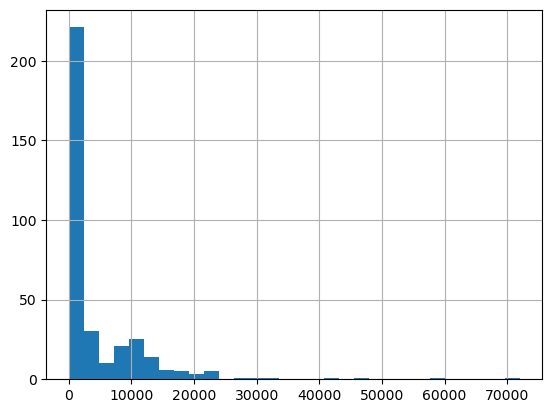

In [10]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df_ko = pd.read_csv('processed/scraped_ko.csv', index_col=0)
df_ko.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df_ko['n_tokens'] = df_ko.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df_ko.n_tokens.hist(bins=30)



## 영어 버전의 경우

<Axes: >

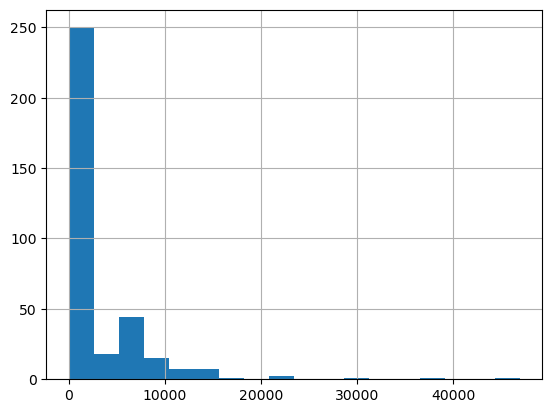

In [11]:
import tiktoken


df_en = pd.read_csv('processed/scraped_en.csv', index_col=0)
df_en.columns = ['title', 'text']

# df_en.tail()
# Tokenize the text and save the number of tokens to a new column
df_en['n_tokens'] = df_en.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df_en.n_tokens.hist(bins=18)


## API 문서(한글)의 경우

<Axes: >

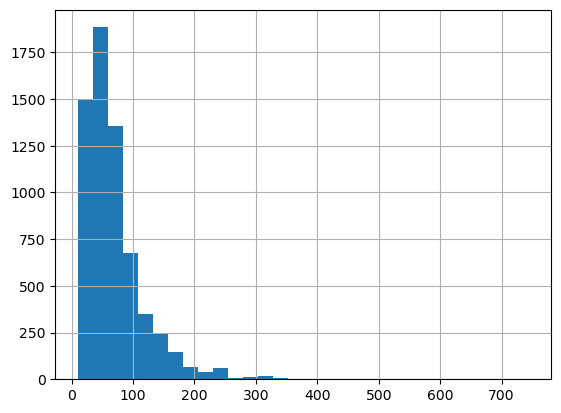

In [12]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df_api_ko = pd.read_csv('processed/api_ko.csv', index_col=0)
df_api_ko.columns = ['유형', 'component', 'name', 'description', 'parameter', 'return', 'exception', 'sample', 'built since', 'built last']
df_api_ko["text"] = df_api_ko['component'].astype(str) +"    "+ df_api_ko["name"].astype(str) +"    "+ df_api_ko["description"].astype(str)

# Tokenize the text and save the number of tokens to a new column
df_api_ko['n_tokens'] = df_api_ko.text.apply(lambda x: len(tokenizer.encode(str(x))))
# df_en['n_tokens'] = df_en.text.apply(lambda x: len(tokenizer.encode(x)))

# # Visualize the distribution of the number of tokens per row using a histogram
df_api_ko.n_tokens.hist(bins=30)

In [13]:
# df_api_ko["text"] = df_api_ko['component'].astype(str) +"    "+ df_api_ko["name"].astype(str) +"    "+ df_api_ko["description"].astype(str)

In [14]:
# df_api_ko['component'] = df_api_ko['component'].astype("string")
# df_api_ko['name'] = df_api_ko['name'].astype("string")
# df_api_ko['description'] = df_api_ko['description'].astype("string")

In [15]:
# df_api_ko['text']

In [16]:
# df_api_ko['description']

In [17]:
# df_api_ko.head()

# 4. 문서를 token (500)이하로 분리하여 저장

In [18]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    chunks.append(". ".join(chunk) + ".")
    return chunks
    


In [19]:
shortened_ko = []

# Loop through the dataframe
for row in df_ko.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened_ko += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened_ko.append( row[1]['text'] )
        

shortened_en = []

# Loop through the dataframe
for row in df_en.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened_en += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened_en.append( row[1]['text'] )


# 5. token 크기 분포 확인

## 한글의 경우

<Axes: >

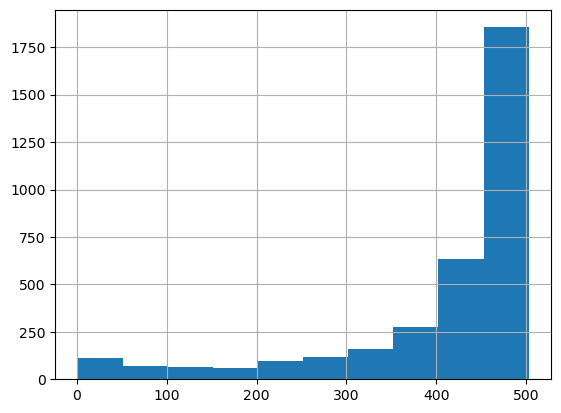

In [21]:
df_ko = pd.DataFrame(shortened_ko, columns = ['text'])
df_ko['n_tokens'] = df_ko.text.apply(lambda x: len(tokenizer.encode(x)))
df_ko.n_tokens.hist()

## 영어의 경우

<Axes: >

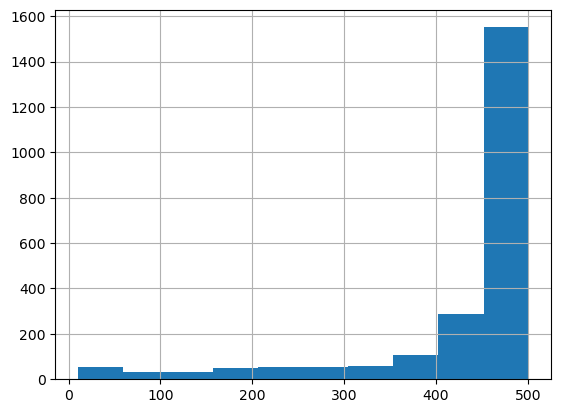

In [22]:
df_en = pd.DataFrame(shortened_en, columns = ['text'])
df_en['n_tokens'] = df_en.text.apply(lambda x: len(tokenizer.encode(x)))
df_en.n_tokens.hist()

# 6. gpt를 이용하여 문서를 정리 및 축약한 다음 작업

## GPT를 이용하여 cleaning하기 위해 문서를 token (2500)이하로 분리하여 저장

In [49]:
max_tokens_cleaning = 2500

cleaning_ko = []

# Loop through the dataframe
for row in df_ko.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens_cleaning:
        cleaning_ko += split_into_many(row[1]['text'], max_tokens=max_tokens_cleaning)
    
    # Otherwise, add the text to the list of shortened texts
    else:
        cleaning_ko.append( row[1]['text'] )
        

cleaning_en = []

# Loop through the dataframe
for row in df_en.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens_cleaning:
        cleaning_en += split_into_many(row[1]['text'], max_tokens=max_tokens_cleaning)
    
    # Otherwise, add the text to the list of shortened texts
    else:
        cleaning_en.append( row[1]['text'] )
        

## 한글의 경우 (cleaning 대상)

<Axes: >

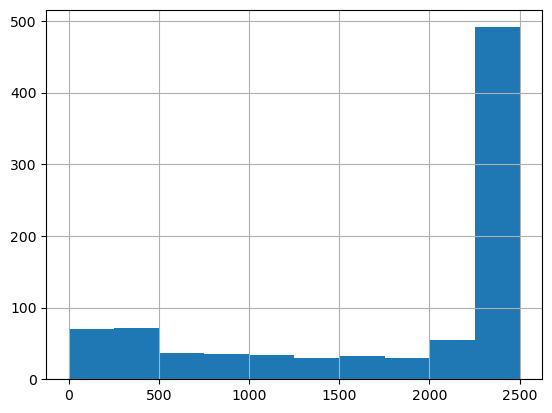

In [23]:
df_cleaning_ko = pd.DataFrame(cleaning_ko, columns = ['text'])
df_cleaning_ko['n_tokens'] = df_cleaning_ko.text.apply(lambda x: len(tokenizer.encode(x)))
df_cleaning_ko.n_tokens.hist()

## 영어의 경우 (cleaning 대상)

<Axes: >

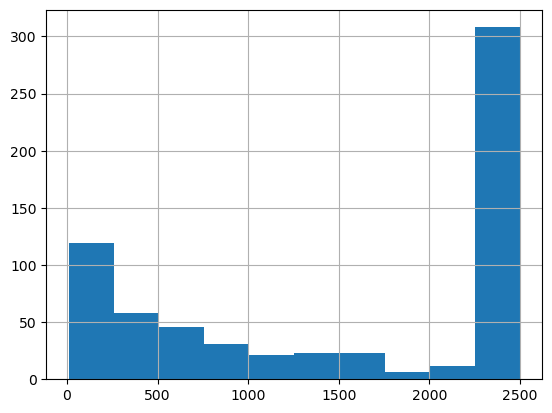

In [24]:
df_cleaning_en = pd.DataFrame(cleaning_en, columns = ['text'])
df_cleaning_en['n_tokens'] = df_cleaning_en.text.apply(lambda x: len(tokenizer.encode(x)))
df_cleaning_en.n_tokens.hist()

In [99]:
df_cleaning_ko.head()

,text,n_tokens
0,80 websquare html websquare.uiplugin.tabContro...,2452
1,"(웹스퀘어 컴포넌트 공통.) getScopeWindow( ) scope=""true""...",2384
2,"closable tab의 닫기 버튼을 활성화 할지의 여부로, 개별 closable ...",2468
3,info.startTabIndex : tab이동을 시작한 tab의 index (화면...,2453
4,} // 새로 생성한 탭에서 전달 받은 데이터를 확인하는 예제 // var para...,2447


In [26]:
df_cleaning_ko.to_csv('processed/before_cleaning_ko.csv')

In [27]:
df_cleaning_en.head()

,text,n_tokens
0,80 websquare html websquare.uiplugin.tabContro...,2492
1,The following property values ​​are forcibly a...,2405
2,info.startTabIndex : The index of the tab wher...,2462
3,Parameter nametyperequireddescription idxNumbe...,2488
4,(Common to Web Square components.) Parameter n...,2492


In [28]:
df_cleaning_en.to_csv('processed/before_cleaning_en.csv')

## gpt-3로 축약 작업 진행 (외부 프로그램으로 진행)

I want you to act as a technical writer and proofreader. You'll be reviewing, rewriting and summarizing for ease of understanding.  Below is detailed instruction.

- Do not give any explanation for your answer. 
- Do not add content that is not in the original text. 
- You can use only the sample or example code in the original text.
- Up to 1400 tokens and no more than 50% the length of the original text. 
- Answer in Korean. 


## 축약 작업 결과를 로드

In [105]:
df_after_cleaning_ko=pd.read_csv('processed/after_cleaning_ko.csv', index_col=0)
df_after_cleaning_ko.head()

,text,n_tokens
0,WebSquare.uiplugin.tabControl은 탭 컨트롤을 구현하는 HTM...,462
1,이 함수들은 웹스퀘어 컴포넌트에서 사용할 수 있는 다양한 기능을 제공한다. getS...,1362
2,"tabControl 컴포넌트는 여러 개의 탭을 관리하고, 각 탭에 대한 설정을 제공...",342
3,"이벤트\n- onbeforeselect: tab이 선택되기 전에 발생되며, retu...",521
4,"이 함수들은 웹스퀘어 컴포넌트에서 사용되는 함수들이며, 각 함수의 기능과 사용 방법...",179


<Axes: >

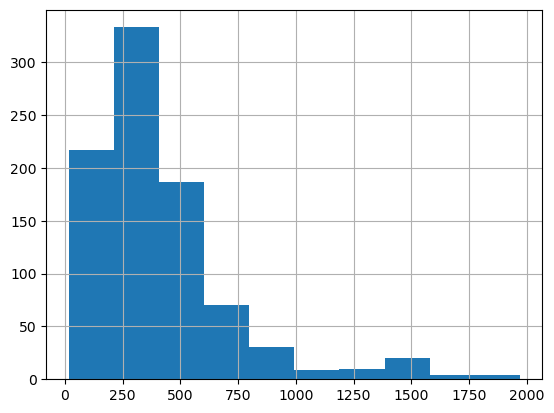

In [106]:
df_after_cleaning_ko = pd.DataFrame(df_after_cleaning_ko, columns = ['text'])
df_after_cleaning_ko['n_tokens'] = df_after_cleaning_ko.text.apply(lambda x: len(tokenizer.encode(x)))
df_after_cleaning_ko.n_tokens.hist()

## 문서를 token (500)이하로 분리하여 저장

In [107]:
shortened_cleaning_ko = []

# Loop through the dataframe
for row in df_after_cleaning_ko.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened_cleaning_ko += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened_cleaning_ko.append( row[1]['text'] )
        

<Axes: >

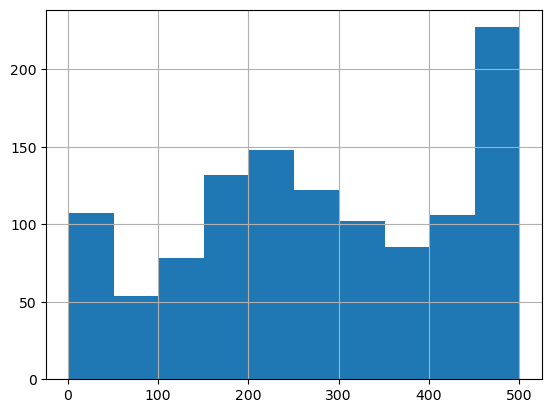

In [108]:
df_after_cleaning_ko = pd.DataFrame(shortened_cleaning_ko, columns = ['text'])
df_after_cleaning_ko['n_tokens'] = df_after_cleaning_ko.text.apply(lambda x: len(tokenizer.encode(x)))
df_after_cleaning_ko.n_tokens.hist()

# 7. OpenAI API를 이용하여 embedding 계산 하여 저장
이미 계산된 파일을 이용하는 경우 실행 불필요 (실행이 필요한 경우 주석을 제거한 다음 실행)

## 원본을 embedding

In [32]:
# import openai

# df_ko['embeddings'] = df_ko.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
# df_ko.to_csv('processed/embeddings_ko.csv')
# df_ko.head()

In [33]:
# import openai

# df_en['embeddings'] = df_en.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
# df_en.to_csv('processed/embeddings_en.csv')
# df_en.head()

## cleaning한 결과를 embedding

In [109]:
import openai

df_after_cleaning_ko['embeddings'] = df_after_cleaning_ko.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df_after_cleaning_ko.to_csv('processed/embeddings_cleaning_ko.csv')
df_after_cleaning_ko.head()

,text,n_tokens,embeddings
0,WebSquare.uiplugin.tabControl은 탭 컨트롤을 구현하는 HTM...,462,"[-0.0004809198435395956, -0.005975246895104647..."
1,이 함수들은 웹스퀘어 컴포넌트에서 사용할 수 있는 다양한 기능을 제공한다. getS...,485,"[0.013541501946747303, 0.006753849796950817, 0..."
2,hideTab(tabIndex) 함수는 tab을 숨김(hidden)처리 한다. is...,483,"[0.00030302564846351743, -0.004649957176297903..."
3,setWidth(width) 함수는 tabControl의 width를 설정하며 px...,393,"[0.004575745202600956, 0.00784219615161419, 0...."
4,"tabControl 컴포넌트는 여러 개의 탭을 관리하고, 각 탭에 대한 설정을 제공...",342,"[-0.009348013438284397, -0.010107745416462421,..."


In [35]:
# import openai

# df_cleaning_en['embeddings'] = df_cleaning_en.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
# df_cleaning_en.to_csv('processed/embeddings_cleaning_en.csv')
# df_cleaning_en.head()

## API를 embedding 

In [36]:
# import openai

# df_api_ko['embeddings'] = df_api_ko.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
# df_api_ko.to_csv('processed/embeddings_api_ko.csv')
# df_api_ko.head()

# 8. embedding이 포함된 파일을 pandas에 로딩

## 한글의 경우

In [110]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df_ko=pd.read_csv('processed/embeddings_ko.csv', index_col=0)
df_ko['embeddings'] = df_ko['embeddings'].apply(eval).apply(np.array)

df_ko.head()


,text,n_tokens,embeddings
0,80 websquare html websquare.uiplugin.tabContro...,461,"[-0.009222293272614479, -0.0069480170495808125..."
1,"closable tab의 닫기 버튼을 활성화 할지의 여부로, 개별 closable ...",496,"[-0.011141913011670113, -0.01115531288087368, ..."
2,"tabRole [default:true, false]tab 컴포넌트의 role=""t...",420,"[-0.008997799828648567, -0.011731056496500969,..."
3,userData1 사용자 정의 데이터 속성 userData2 사용자 정의 데이터 속...,487,"[-0.004409090615808964, -0.024778474122285843,..."
4,"bind( eventType , function ) 컴포넌트에 이벤트와 핸들러 함수...",427,"[-0.013010666705667973, -0.0002241010370198637..."


## 영어의 경우

In [111]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df_en=pd.read_csv('processed/embeddings_en.csv', index_col=0)
df_en['embeddings'] = df_en['embeddings'].apply(eval).apply(np.array)

df_en.head()


,text,n_tokens,embeddings
0,80 websquare html websquare.uiplugin.tabContro...,471,"[-0.005918701644986868, 0.005215943790972233, ..."
1,"When the noUseTitle tabScroll option is used, ...",494,"[-0.01587953045964241, -0.0022740792483091354,..."
2,windowMaxNum [default:-1] If -1 is set as the ...,436,"[-0.002756500383839011, -0.017225049436092377,..."
3,getGenerator( ) Returns the parent generator o...,492,"[0.015154805965721607, 0.0009454326354898512, ..."
4,getWindow(idx) The window corresponding to the...,498,"[0.004514731932431459, 0.007678211200982332, 0..."


## 축약 버전의 경우

In [112]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df_after_cleaning_ko=pd.read_csv('processed/embeddings_cleaning_ko.csv', index_col=0)
df_after_cleaning_ko['embeddings'] = df_after_cleaning_ko['embeddings'].apply(eval).apply(np.array)

df_after_cleaning_ko.head()


,text,n_tokens,embeddings
0,WebSquare.uiplugin.tabControl은 탭 컨트롤을 구현하는 HTM...,462,"[-0.0004809198435395956, -0.005975246895104647..."
1,이 함수들은 웹스퀘어 컴포넌트에서 사용할 수 있는 다양한 기능을 제공한다. getS...,485,"[0.013541501946747303, 0.006753849796950817, 0..."
2,hideTab(tabIndex) 함수는 tab을 숨김(hidden)처리 한다. is...,483,"[0.00030302564846351743, -0.004649957176297903..."
3,setWidth(width) 함수는 tabControl의 width를 설정하며 px...,393,"[0.004575745202600956, 0.00784219615161419, 0...."
4,"tabControl 컴포넌트는 여러 개의 탭을 관리하고, 각 탭에 대한 설정을 제공...",342,"[-0.009348013438284397, -0.010107745416462421,..."


## API의 경우

In [113]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df_api_ko=pd.read_csv('processed/embeddings_api_ko.csv', index_col=0)
df_api_ko['embeddings'] = df_api_ko['embeddings'].apply(eval).apply(np.array)

df_api_ko.head()


,유형,component,name,description,parameter,return,exception,sample,built since,built last,text,n_tokens,embeddings
0,method,$p,$,jQuery selector를 인자로 받아 jQuery 객체를 반환한다. <br /...,NaN,Object\tjQuery 객체,NaN,"$p.$(""#group1"").wq(""invoke"", ""setDisabled"", ""t...",5.0_3.3377A.20181128.161740,5.0_5.4811B.20230203.095105,$p $ jQuery selector를 인자로 받아 jQuery 객체를 ...,74,"[0.01099808607250452, -0.005163693800568581, 0..."
1,method,$p,URLEncoder,주어진 문자열을 `application/x-www-form-urlencoded` M...,str\tString\tY\t문자열,String\t변환된 application/x-www-form-urlencoded ...,NaN,<xmp class='js sample'>var encodeStr = $p.URL...,5.0_3.3377A.20181128.161740,5.0_5.4811B.20230203.095105,$p URLEncoder 주어진 문자열을 `application/x-ww...,30,"[0.031562093645334244, 0.02055238001048565, 0...."
2,method,$p,ajax,submission과 비슷한 기능을 제공하는 통신 모듈로 submission에 비해...,options\tJSON\tY\tJSON형태 객체<br />\n<xmp class=...,\t,NaN,<xmp class='js sample'>var options = {};\nopt...,5.0_3.3377A.20181128.161740,5.0_5.4811B.20230203.095105,$p ajax submission과 비슷한 기능을 제공하는 통신 모듈로 ...,78,"[0.006162634585052729, -0.006649068556725979, ..."
3,method,$p,clearInterval,$p.setInterval으로 등록된 Interval 객체를 해제합니다.,keyName\tString\tY\tkey로 지정한 값. ( $p.setInterv...,\t,NaN,<xmp class='js sample'>//$p.setInterval API를 ...,5.0_3.3377A.20181128.161740,5.0_5.4811B.20230203.095105,$p clearInterval $p.setInterval으로 등록된 In...,19,"[0.005675738677382469, 0.0083992350846529, 0.0..."
4,method,$p,clearPage,"브라우저를 초기 상태로 되돌리는 함수이며, 이 함수를 사용하여 웹스퀘어 엔진 및 리...",NaN,\t,NaN,<xmp class='js sample'><body>\n <script ty...,5.0_3.3377A.20181128.161740,5.0_5.4811B.20230203.095105,"$p clearPage 브라우저를 초기 상태로 되돌리는 함수이며, 이 함...",213,"[0.005665027070790529, 0.01029566116631031, 0...."


# 9. gpt에 전달할 context 생성

1. 질문의 embedding 생성
2. 질문과 기존 embedding의 유사도를 계산하여 가장 높은 항목 추출
3. max_token (1500)을 초과하지 않는 범위에서 유사도가 높은 항목을 context로 생성
4. OpenAI에서 제공하는 api 호출


* answer_question_chat는 chat api 사용
* answer_question_completion는 completion api 사용 

In [114]:
def create_context(
    question, df, max_len=1500, debug=False
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0
    prev_distance = 0
    prev_msg = ""

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        if prev_distance == row['distances']:
#             print("이전 목록과 동일 (distance)")
            continue
        elif prev_msg == row['text']:
#             print("이전 목록과 동일 (문자열)")
            continue
        else:
            prev_distance = row['distances']
            prev_msg = row['text']            

            # Add the length of the text to the current length
            cur_len += row['n_tokens'] + 4

            # If the context is too long, break
            if cur_len > max_len:
                break

            if debug:
                print(i, row['distances'], row['text'])
            # Else add it to the text that is being returned
            returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)


def answer_question_chat(
    df,
    model="gpt-3.5-turbo",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=3000,
    debug=False,
#     max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        debug=debug
    )
    # If debug, print the raw model response
    if debug:
        print("\n\nContext:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "user", "content": f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:"}
            ],
            temperature=0,
#             max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
        )

        return response["choices"][0]["message"]["content"].strip()
    except Exception as e:
        print(e)
        return ""

def answer_question_completion(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=2000,
    debug=False,
#     max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        debug=debug
    )
    # If debug, print the raw model response
    if debug:
        print("\n\nContext:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}:\nAnswer:",
            temperature=0,
#             max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

def search_context(
    df, question, max_cnt=5, debug=False
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_cnt = 0
    prev_distance = 0
    prev_msg = ""

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        if prev_distance == row['distances']:
            print("이전 목록과 동일 (distance)")
            continue
        elif prev_msg == row['text']:
            print("이전 목록과 동일 (문자열)")
            continue
        else:
            prev_distance = row['distances']
            prev_msg = row['text']

            # Add the length of the text to the current length
            cur_cnt += 1

            # If the context is too long, break
            if cur_cnt > max_cnt:
                break

#             if debug:
            print(i, row['distances'], row['text'])
            # Else add it to the text that is being returned
            returns.append(row["text"])

    # Return the context
    return "\n\n---\n\n".join(returns)


# 10. gpt를 이용하여 질문/답변 확인

gpt4를 사용하려고 하는 경우 answer_question_chat 함수에 model="gpt-4" 인자를 추가하면 됨

In [115]:
answer_question_chat(df_ko, question="What day is it?", debug=False)

"I don't know."

In [116]:
answer_question_chat(df_en, question="What day is it?", debug=False)

"I don't know."

In [117]:
answer_question_chat(df_after_cleaning_ko, question="What day is it?", debug=False)

"I don't know."

In [118]:
answer_question_chat(df_ko, question="What is our newest embeddings model?", debug=False)

"I don't know."

In [119]:
answer_question_chat(df_en, question="What is our newest embeddings model?", debug=False)

"I don't know."

In [120]:
answer_question_chat(df_after_cleaning_ko, question="What is our newest embeddings model?", debug=False)

"I don't know."

In [121]:
answer_question_chat(df_ko, question="gridView에서 엑셀을 다운로드하려면?", debug=False)

'GridView에서 엑셀을 다운로드하려면 advancedExcelDownload 함수를 사용해야 합니다. 함수를 호출할 때 다양한 옵션을 설정할 수 있으며, 예제 파일이나 WEBSQUARE_DEV_PACK의 GUIDE 프로젝트에서 확인할 수 있습니다.'

In [122]:
answer_question_chat(df_en, question="gridView에서 엑셀을 다운로드하려면?", debug=False)

'advancedExcelDownload() 함수를 사용해야 한다.'

In [123]:
answer_question_chat(df_after_cleaning_ko, question="gridView에서 엑셀을 다운로드하려면?", debug=False)

'GridView에서는 advancedExcelDownload() 함수를 사용하여 엑셀 파일을 다운로드할 수 있습니다. 이 함수에는 다양한 옵션들이 있으며, 파일 이름, 출력할 데이터의 표시 형식, 포맷을 적용하기 위한 사용자 함수 등을 지정할 수 있습니다. 또한, options 객체를 사용하여 다운로드 옵션 파일 정보를 입력할 수 있습니다.'

In [124]:
answer_question_chat(df_ko, question="autoComplete에서 항목을 서버에서 동적으로 조회하려면 어떤 속성이나 API를 이용해야 하나요?", debug=False)

'interactionMode 속성을 true로 설정하여 사용자 입력에 따라 서버로부터 데이터를 동적으로 받아올 수 있습니다.'

In [125]:
answer_question_chat(df_en, question="autoComplete에서 항목을 서버에서 동적으로 조회하려면 어떤 속성이나 API를 이용해야 하나요?", debug=False)

'interactionMode 속성을 이용해야 합니다.'

In [126]:
answer_question_chat(df_after_cleaning_ko, question="autoComplete에서 항목을 서버에서 동적으로 조회하려면 어떤 속성이나 API를 이용해야 하나요?", debug=False)

'interactionMode 속성을 이용하여 사용자 입력에 따라 서버로부터 데이터를 동적으로 받아 항목을 생성할 수 있습니다.'

In [127]:
answer_question_chat(df_ko, question="autoComplete에서 항목을 서버에서 조회하려면 API?", debug=False)

'API는 setSelectedIndex() 나 setValue()를 사용하여 항목을 서버에서 조회할 수 있습니다.'

In [128]:
answer_question_chat(df_en, question="autoComplete에서 항목을 서버에서 조회하려면 API?", debug=False)

'The API for retrieving the corresponding list from the server in real time using the Enter key or user key input is provided, but the specific API is not mentioned in the given context.'

In [129]:
answer_question_chat(df_after_cleaning_ko, question="autoComplete에서 항목을 서버에서 조회하려면 API?", debug=False)

"I don't know."

In [130]:
answer_question_completion(df_ko, question="autoComplete에서 항목을 서버에서 동적으로 조회하려면 어떤 속성이나 API를 이용해야 하나요?", debug=False)

'interactionMode 속성과 search API를'

In [131]:
answer_question_completion(df_en, question="autoComplete에서 항목을 서버에서 동적으로 조회하려면 어떤 속성이나 API를 이용해야 하나요?", debug=False)

'interactionMode 속성을 이용'

In [132]:
answer_question_completion(df_after_cleaning_ko, question="autoComplete에서 항목을 서버에서 동적으로 조회하려면 어떤 속성이나 API를 이용해야 하나요?", debug=False)

This model's maximum context length is 4097 tokens, however you requested 4602 tokens (4586 in your prompt; 16 for the completion). Please reduce your prompt; or completion length.


''

In [133]:
answer_question_chat(df_ko, question="첨부드린 이미지 처럼 그리드에서 특정 행이나 버튼을 클릭시 그 행에 포함되어 숨어있던 하위 행들을 노출할수 있는기능이 가능할런지요? 기능 구현상 가능여부 확인이 필요하여 문의 드립니다.전체목록열기 버튼 클릭시 기본 노출되는 행 아래로 숨어있던 전체 행들이 나타나게 구현하고자 합니다.혹여 그리드가 안된다면 다른 방법이 있을지도 추가 문의 드립니다.확인 요청 드립니다. 감사합니다.")

'The context does not provide information on whether the mentioned feature is possible or not.'

In [134]:
answer_question_chat(df_en, question="첨부드린 이미지 처럼 그리드에서 특정 행이나 버튼을 클릭시 그 행에 포함되어 숨어있던 하위 행들을 노출할수 있는기능이 가능할런지요? 기능 구현상 가능여부 확인이 필요하여 문의 드립니다.전체목록열기 버튼 클릭시 기본 노출되는 행 아래로 숨어있던 전체 행들이 나타나게 구현하고자 합니다.혹여 그리드가 안된다면 다른 방법이 있을지도 추가 문의 드립니다.확인 요청 드립니다. 감사합니다.")

'It is not clear from the context whether the specific functionality of clicking a row or button to reveal hidden sub-rows is possible in the grid. Further clarification or testing may be necessary to determine if this feature can be implemented.'

In [135]:
answer_question_chat(df_after_cleaning_ko, question="첨부드린 이미지 처럼 그리드에서 특정 행이나 버튼을 클릭시 그 행에 포함되어 숨어있던 하위 행들을 노출할수 있는기능이 가능할런지요? 기능 구현상 가능여부 확인이 필요하여 문의 드립니다.전체목록열기 버튼 클릭시 기본 노출되는 행 아래로 숨어있던 전체 행들이 나타나게 구현하고자 합니다.혹여 그리드가 안된다면 다른 방법이 있을지도 추가 문의 드립니다.확인 요청 드립니다. 감사합니다.")

"I don't know. The context does not provide information on whether the specific feature mentioned in the question is available in the GridView component."

In [161]:
answer_question_chat(df_ko, question="그리드 특정 행 버튼 클릭 하위 행 노출 기능 가능여부 확인 전체목록열기 버튼 기본 노출 행 아래 전체 행 나타나게 구현 다른 방법 추가 문의 확인 요청")

"I don't know."

In [160]:
answer_question_chat(df_en, question="그리드 특정 행 버튼 클릭 하위 행 노출 기능 가능여부 확인 전체목록열기 버튼 기본 노출 행 아래 전체 행 나타나게 구현 다른 방법 추가 문의 확인 요청")

"I don't know."

In [158]:
answer_question_chat(df_after_cleaning_ko, question="그리드 특정 행 버튼 클릭 하위 행 노출 기능 가능여부 확인 전체목록열기 버튼 기본 노출 행 아래 전체 행 나타나게 구현 다른 방법 추가 문의 확인 요청")

"I don't know. The context does not provide enough information to answer the question."

In [136]:
answer_question_chat(df_ko, question="그리드에서 특정 행이나 버튼을 클릭시 그 행에 포함되어 숨어있던 하위 행들을 노출할수 있는기능이 가능할런지요? 기능 구현상 가능여부 확인이 필요하여 문의 드립니다.전체목록열기 버튼 클릭시 기본 노출되는 행 아래로 숨어있던 전체 행들이 나타나게 구현하고자 합니다.혹여 그리드가 안된다면 다른 방법이 있을지도 추가 문의 드립니다.")

"I don't know."

In [137]:
answer_question_chat(df_en, question="그리드에서 특정 행이나 버튼을 클릭시 그 행에 포함되어 숨어있던 하위 행들을 노출할수 있는기능이 가능할런지요? 기능 구현상 가능여부 확인이 필요하여 문의 드립니다.전체목록열기 버튼 클릭시 기본 노출되는 행 아래로 숨어있던 전체 행들이 나타나게 구현하고자 합니다.혹여 그리드가 안된다면 다른 방법이 있을지도 추가 문의 드립니다.")

'The question is not directly addressed in the given context.'

In [138]:
answer_question_chat(df_after_cleaning_ko, question="그리드에서 특정 행이나 버튼을 클릭시 그 행에 포함되어 숨어있던 하위 행들을 노출할수 있는기능이 가능할런지요? 기능 구현상 가능여부 확인이 필요하여 문의 드립니다.전체목록열기 버튼 클릭시 기본 노출되는 행 아래로 숨어있던 전체 행들이 나타나게 구현하고자 합니다.혹여 그리드가 안된다면 다른 방법이 있을지도 추가 문의 드립니다.")

'가능합니다. 이러한 기능은 drilldownToggle 속성을 사용하여 구현할 수 있습니다. 이 속성을 사용하면, inputType="drilldown" 컬럼에서 드릴다운을 펼치는 방식을 선택할 수 있습니다. 따라서, 특정 행이나 버튼을 클릭하여 하위 행들을 노출시키는 기능을 구현할 수 있습니다.'

In [139]:
answer_question_chat(df_ko, model="gpt-4", question="그리드에서 특정 행이나 버튼을 클릭시 그 행에 포함되어 숨어있던 하위 행들을 노출할수 있는기능이 가능할런지요? 기능 구현상 가능여부 확인이 필요하여 문의 드립니다.전체목록열기 버튼 클릭시 기본 노출되는 행 아래로 숨어있던 전체 행들이 나타나게 구현하고자 합니다.혹여 그리드가 안된다면 다른 방법이 있을지도 추가 문의 드립니다.")

'그리드에서 drilldown 기능을 사용하면 특정 행이나 버튼을 클릭 시 그 행에 포함되어 숨어있던 하위 행들을 노출할 수 있습니다. 이 기능을 구현하려면 hasChild() 함수를 사용하여 해당 행이 하위 행을 가지고 있는지 확인하고, drillTo() 함수를 사용하여 해당 행의 하위 행들을 오픈할 수 있습니다. 이 외에도 다양한 그리드 관련 함수들을 사용하여 원하는 기능을 구현할 수 있습니다.'

In [140]:
answer_question_chat(df_en, model="gpt-4", question="그리드에서 특정 행이나 버튼을 클릭시 그 행에 포함되어 숨어있던 하위 행들을 노출할수 있는기능이 가능할런지요? 기능 구현상 가능여부 확인이 필요하여 문의 드립니다.전체목록열기 버튼 클릭시 기본 노출되는 행 아래로 숨어있던 전체 행들이 나타나게 구현하고자 합니다.혹여 그리드가 안된다면 다른 방법이 있을지도 추가 문의 드립니다.")

"I don't know"

In [141]:
answer_question_chat(df_after_cleaning_ko, model="gpt-4", question="그리드에서 특정 행이나 버튼을 클릭시 그 행에 포함되어 숨어있던 하위 행들을 노출할수 있는기능이 가능할런지요? 기능 구현상 가능여부 확인이 필요하여 문의 드립니다.전체목록열기 버튼 클릭시 기본 노출되는 행 아래로 숨어있던 전체 행들이 나타나게 구현하고자 합니다.혹여 그리드가 안된다면 다른 방법이 있을지도 추가 문의 드립니다.")

'그리드에서 특정 행이나 버튼을 클릭하여 하위 행들을 노출하는 기능은 가능합니다. 이를 구현하기 위해 setRowVisible 및 clearRowVisible 함수를 사용하여 행을 숨기거나 표시할 수 있습니다. 전체 목록 열기 버튼 클릭 시 기본 노출되는 행 아래로 숨어있던 전체 행들이 나타나게 구현할 수 있습니다.'

In [142]:
answer_question_chat(df_ko, question="첨부드린 이미지 처럼 그리드에서 특정 행이나 버튼을 클릭시 그 행에 포함되어 숨어있던 하위 행들을 노출할수 있는기능이 가능할런지요? 기능 구현상 가능여부 확인이 필요하여 문의 드립니다.전체목록열기 버튼 클릭시 기본 노출되는 행 아래로 숨어있던 전체 행들이 나타나게 구현하고자 합니다.혹여 그리드가 안된다면 다른 방법이 있을지도 추가 문의 드립니다.")

'The context does not provide information on whether the specific feature of clicking a row or button to reveal hidden sub-rows is possible in the Grid component.'

In [143]:
answer_question_chat(df_en, question="첨부드린 이미지 처럼 그리드에서 특정 행이나 버튼을 클릭시 그 행에 포함되어 숨어있던 하위 행들을 노출할수 있는기능이 가능할런지요? 기능 구현상 가능여부 확인이 필요하여 문의 드립니다.전체목록열기 버튼 클릭시 기본 노출되는 행 아래로 숨어있던 전체 행들이 나타나게 구현하고자 합니다.혹여 그리드가 안된다면 다른 방법이 있을지도 추가 문의 드립니다.")

'It is not clear from the context whether the grid component has the functionality to display hidden rows when a specific row or button is clicked. Further clarification or research is needed.'

In [144]:
answer_question_chat(df_after_cleaning_ko, question="첨부드린 이미지 처럼 그리드에서 특정 행이나 버튼을 클릭시 그 행에 포함되어 숨어있던 하위 행들을 노출할수 있는기능이 가능할런지요? 기능 구현상 가능여부 확인이 필요하여 문의 드립니다.전체목록열기 버튼 클릭시 기본 노출되는 행 아래로 숨어있던 전체 행들이 나타나게 구현하고자 합니다.혹여 그리드가 안된다면 다른 방법이 있을지도 추가 문의 드립니다.")

"I don't know. The context does not provide information on whether the described feature is possible or not."

In [145]:
answer_question_chat(df_ko, question='''pivotExcelDownload 엑셀 다운로드시 표 상단을 병합 후 제목을 적으려고합니다. 
header에 열의 수만큼 병합하려합니다. 열의 수를 알 수 있는 방법이 있을까요?

예시) 

                                        제목 : 00 빈도수 분포
 
 	열1	열2
 	 	 
 	 	 
''')

"I don't know."

In [146]:
answer_question_chat(df_en, question='''pivotExcelDownload 엑셀 다운로드시 표 상단을 병합 후 제목을 적으려고합니다. 
header에 열의 수만큼 병합하려합니다. 열의 수를 알 수 있는 방법이 있을까요?

예시) 

                                        제목 : 00 빈도수 분포
 
 	열1	열2
 	 	 
 	 	 
''')

'There is no information provided in the context on how to determine the number of columns in the pivot table, so it is not possible to answer the question.'

In [147]:
answer_question_chat(df_after_cleaning_ko, question='''pivotExcelDownload 엑셀 다운로드시 표 상단을 병합 후 제목을 적으려고합니다. 
header에 열의 수만큼 병합하려합니다. 열의 수를 알 수 있는 방법이 있을까요?

예시) 

                                        제목 : 00 빈도수 분포
 
 	열1	열2
 	 	 
 	 	 
''')

"I don't know."

In [148]:
answer_question_chat(df_ko, model="gpt-4", debug=False, question='''pivotExcelDownload 엑셀 다운로드시 표 상단을 병합 후 제목을 적으려고합니다. 
header에 열의 수만큼 병합하려합니다. 열의 수를 알 수 있는 방법이 있을까요?

예시) 

                                        제목 : 00 빈도수 분포
 
 	열1	열2
 	 	 
 	 	 
''')

"I don't know"

In [149]:
answer_question_chat(df_en, model="gpt-4", debug=False, question='''pivotExcelDownload 엑셀 다운로드시 표 상단을 병합 후 제목을 적으려고합니다. 
header에 열의 수만큼 병합하려합니다. 열의 수를 알 수 있는 방법이 있을까요?

예시) 

                                        제목 : 00 빈도수 분포
 
 	열1	열2
 	 	 
 	 	 
''')

"I don't know"

In [150]:
answer_question_chat(df_after_cleaning_ko, model="gpt-4", debug=False, question='''pivotExcelDownload 엑셀 다운로드시 표 상단을 병합 후 제목을 적으려고합니다. 
header에 열의 수만큼 병합하려합니다. 열의 수를 알 수 있는 방법이 있을까요?

예시) 

                                        제목 : 00 빈도수 분포
 
 	열1	열2
 	 	 
 	 	 
''')

"I don't know"

In [155]:
answer_question_chat(df_ko, debug=False, question='pivotExcelDownload 엑셀 다운로드 표 상단 병합 제목 작성 header 열 수 병합 방법 알 수 있음')

"I don't know."

In [156]:
answer_question_chat(df_en, debug=False, question='pivotExcelDownload 엑셀 다운로드 표 상단 병합 제목 작성 header 열 수 병합 방법 알 수 있음')

"I don't know."

In [157]:
answer_question_chat(df_after_cleaning_ko, debug=False, question='pivotExcelDownload 엑셀 다운로드 표 상단 병합 제목 작성 header 열 수 병합 방법 알 수 있음')

"I don't know."

In [151]:
answer_question_chat(df_ko, model="gpt-4", debug=False, question='''pivotExcelDownload 엑셀 다운로드시 표 상단을 병합 후 제목을 적으려고합니다. 
header에 열의 수만큼 병합하려합니다. 열의 수를 알 수 있는 방법이 있을까요?''')

"I don't know"

In [152]:
answer_question_chat(df_en, model="gpt-4", debug=False, question='''pivotExcelDownload 엑셀 다운로드시 표 상단을 병합 후 제목을 적으려고합니다. 
header에 열의 수만큼 병합하려합니다. 열의 수를 알 수 있는 방법이 있을까요?''')

"I don't know"

In [153]:
answer_question_chat(df_after_cleaning_ko, model="gpt-4", debug=False, question='''pivotExcelDownload 엑셀 다운로드시 표 상단을 병합 후 제목을 적으려고합니다. 
header에 열의 수만큼 병합하려합니다. 열의 수를 알 수 있는 방법이 있을까요?''')

"I don't know"

# 11. embedding을 통한 API 검색

In [154]:
search_context(df_api_ko, question="엑셀 업로드")

1983 0.15756630139428018 WebSquare.uiplugin.grid    advancedExcelUpload    JDK 1.5 이상에서 사용 가능한 기능으로, 엑셀 파일을 읽어 그리드의 데이터를 설정합니다.
2529 0.16081659552261152 WebSquare.uiplugin.gridView    advancedExcelUpload    엑셀 파일을 읽어 그리드의 데이터를 설정. (JDK 1.5 이상에서 사용 가능)<br />업로드하는 엑셀 파일이 Excel 97 이상인 경우 지원. (Excel 5.0/7.0 미지원.)
1982 0.16084245701004884 WebSquare.uiplugin.grid    advancedExcelDownload    JDK 1.5 이상에서 사용 가능한 기능으로, 그리드의 데이터를 엑셀 파일로 저장합니다.
2262 0.1648847538627104 WebSquare.uiplugin.grid    onfilereadend    엑셀 업로드가 완료된 경우 발생합니다.
2783 0.1670759963839029 WebSquare.uiplugin.gridView    onfilereadend    gridView에 엑셀 업로드가 끝난 뒤 발생.


'WebSquare.uiplugin.grid    advancedExcelUpload    JDK 1.5 이상에서 사용 가능한 기능으로, 엑셀 파일을 읽어 그리드의 데이터를 설정합니다.\n\n---\n\nWebSquare.uiplugin.gridView    advancedExcelUpload    엑셀 파일을 읽어 그리드의 데이터를 설정. (JDK 1.5 이상에서 사용 가능)<br />업로드하는 엑셀 파일이 Excel 97 이상인 경우 지원. (Excel 5.0/7.0 미지원.)\n\n---\n\nWebSquare.uiplugin.grid    advancedExcelDownload    JDK 1.5 이상에서 사용 가능한 기능으로, 그리드의 데이터를 엑셀 파일로 저장합니다.\n\n---\n\nWebSquare.uiplugin.grid    onfilereadend    엑셀 업로드가 완료된 경우 발생합니다.\n\n---\n\nWebSquare.uiplugin.gridView    onfilereadend    gridView에 엑셀 업로드가 끝난 뒤 발생.'